# Análisis de Componentes Independientes (ICA)

Este notebook explica paso a paso el proceso de Análisis de Componentes Independientes (ICA), una técnica poderosa para separar señales mezcladas en sus componentes originales. ICA es ampliamente utilizado en procesamiento de señales, especialmente para problemas como la separación ciega de fuentes.


## 1. Introducción al ICA

### ¿Qué es ICA?

El Análisis de Componentes Independientes (ICA) es una técnica estadística que busca encontrar una representación lineal de datos no gaussianos de manera que los componentes sean estadísticamente independientes. A diferencia del Análisis de Componentes Principales (PCA), que busca componentes no correlacionados que maximizan la varianza, ICA busca componentes que sean lo más independientes posible.

### Aplicaciones de ICA

ICA tiene numerosas aplicaciones en procesamiento de señales:

- **Separación ciega de fuentes**: Separar señales mezcladas (como voces en una habitación)
- **Eliminación de artefactos**: Remover ruido o interferencias en señales biomédicas (EEG, ECG)
- **Procesamiento de imágenes**: Separar componentes independientes en imágenes
- **Análisis de datos financieros**: Identificar factores independientes en series temporales financieras
- **Telecomunicaciones**: Separar señales en sistemas de comunicación

### El problema del "cocktail party"

El problema clásico que resuelve ICA es el llamado "problema del cocktail party": imagina una habitación con varias personas hablando simultáneamente y varios micrófonos grabando. Cada micrófono capta una mezcla diferente de las voces. ICA permite recuperar las voces individuales a partir de estas grabaciones mezcladas.


## 2. Fundamentos Teóricos

### Modelo Matemático

El modelo básico de ICA se puede expresar como:

$$X = AS$$

Donde:
- $X$ es la matriz de señales observadas (mezcladas)
- $S$ es la matriz de señales fuente (independientes)
- $A$ es la matriz de mezcla

El objetivo de ICA es estimar $S$ y $A$ conociendo solo $X$.

### Supuestos de ICA

Para que ICA funcione correctamente, se deben cumplir ciertos supuestos:

1. **Independencia estadística**: Las fuentes deben ser estadísticamente independientes entre sí
2. **Distribución no gaussiana**: Al menos todas las fuentes menos una deben tener distribución no gaussiana
3. **Matriz de mezcla invertible**: El número de mezclas debe ser mayor o igual al número de fuentes

### Diferencias entre ICA y PCA

| Característica | PCA | ICA |
|----------------|-----|-----|
| Objetivo | Maximizar varianza | Maximizar independencia estadística |
| Restricción | Componentes ortogonales | Componentes independientes |
| Distribución | Funciona con cualquier distribución | Requiere distribuciones no gaussianas |
| Orden de componentes | Ordenados por varianza | Sin orden específico |
| Aplicación típica | Reducción de dimensionalidad | Separación de fuentes |


## 3. Implementación de ICA

Vamos a implementar ICA paso a paso utilizando un ejemplo con señales sintéticas. Primero, importamos las bibliotecas necesarias:


In [128]:
# Importamos las bibliotecas necesarias
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.decomposition import FastICA
import seaborn as sns

# Configuración para visualizaciones
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_palette('viridis')


### 3.1 Generación de Señales Fuente

Primero, generamos tres señales fuente independientes: una señal sinusoidal, una señal cuadrada y una señal de diente de sierra.


In [129]:
# Establecemos una semilla para reproducibilidad
np.random.seed(0)

# Generamos datos de muestra
n_samples = 2000
time = np.linspace(0, 8, n_samples)

# Creamos tres señales fuente independientes
s1 = np.sin(2 * time)  # Señal 1: señal sinusoidal
s2 = np.sign(np.sin(3 * time))  # Señal 2: señal cuadrada
s3 = signal.sawtooth(2 * np.pi * time)  # Señal 3: señal de diente de sierra

# Combinamos las señales en una matriz
S = np.c_[s1, s2, s3]

# Añadimos un poco de ruido
S += 0.2 * np.random.normal(size=S.shape)

# Estandarizamos los datos
S /= S.std(axis=0)


### Visualización de las Señales Fuente

Vamos a visualizar las señales fuente originales:


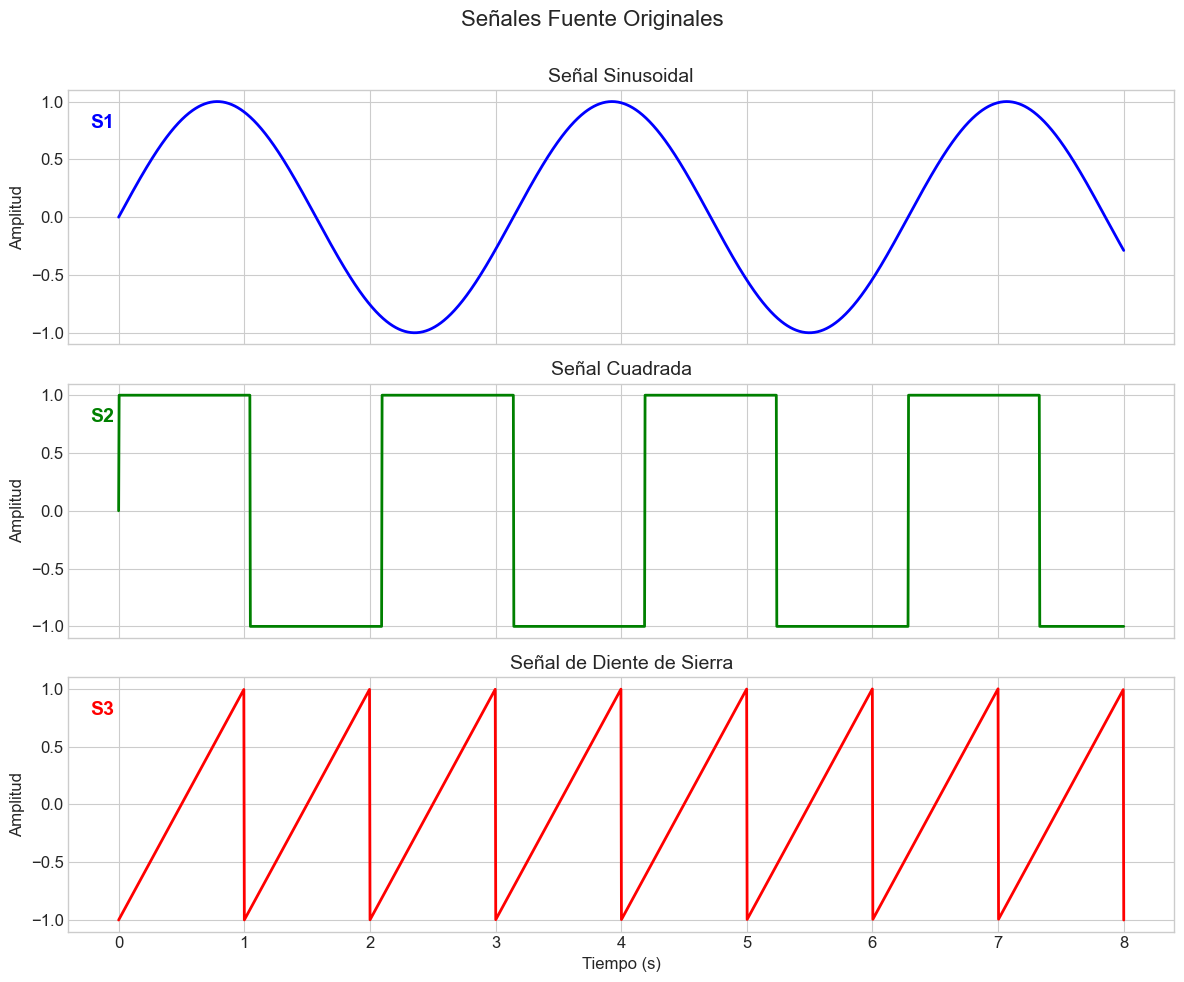

In [130]:
# Visualizamos las señales fuente originales
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
fig.suptitle('Señales Fuente Originales', fontsize=16)

signals = [s1, s2, s3]
titles = ['Señal Sinusoidal', 'Señal Cuadrada', 'Señal de Diente de Sierra']
colors = ['blue', 'green', 'red']

for i, (ax, signal, title, color) in enumerate(zip(axes, signals, titles, colors)):
    ax.plot(time, signal, color=color, lw=2)
    ax.set_title(title, fontsize=14)
    ax.set_ylabel('Amplitud', fontsize=12)
    ax.grid(True)

    # Añadimos una etiqueta para identificar la fuente
    ax.text(0.02, 0.85, f'S{i+1}', transform=ax.transAxes, 
            fontsize=14, fontweight='bold', color=color)

axes[-1].set_xlabel('Tiempo (s)', fontsize=12)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


### 3.2 Mezcla de Señales

Ahora, mezclamos las señales fuente utilizando una matriz de mezcla para simular el proceso de observación de señales mezcladas.


In [122]:
# Definimos la matriz de mezcla
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Matriz de mezcla

# Generamos las observaciones mezcladas
X = np.dot(S, A.T)

print("Forma de la matriz de mezcla A:", A.shape)
print("Forma de la matriz de señales fuente S:", S.shape)
print("Forma de la matriz de señales mezcladas X:", X.shape)


Forma de la matriz de mezcla A: (3, 3)
Forma de la matriz de señales fuente S: (2000, 3)
Forma de la matriz de señales mezcladas X: (2000, 3)


### Visualización de las Señales Mezcladas

Visualizamos las señales mezcladas que serían nuestras observaciones:


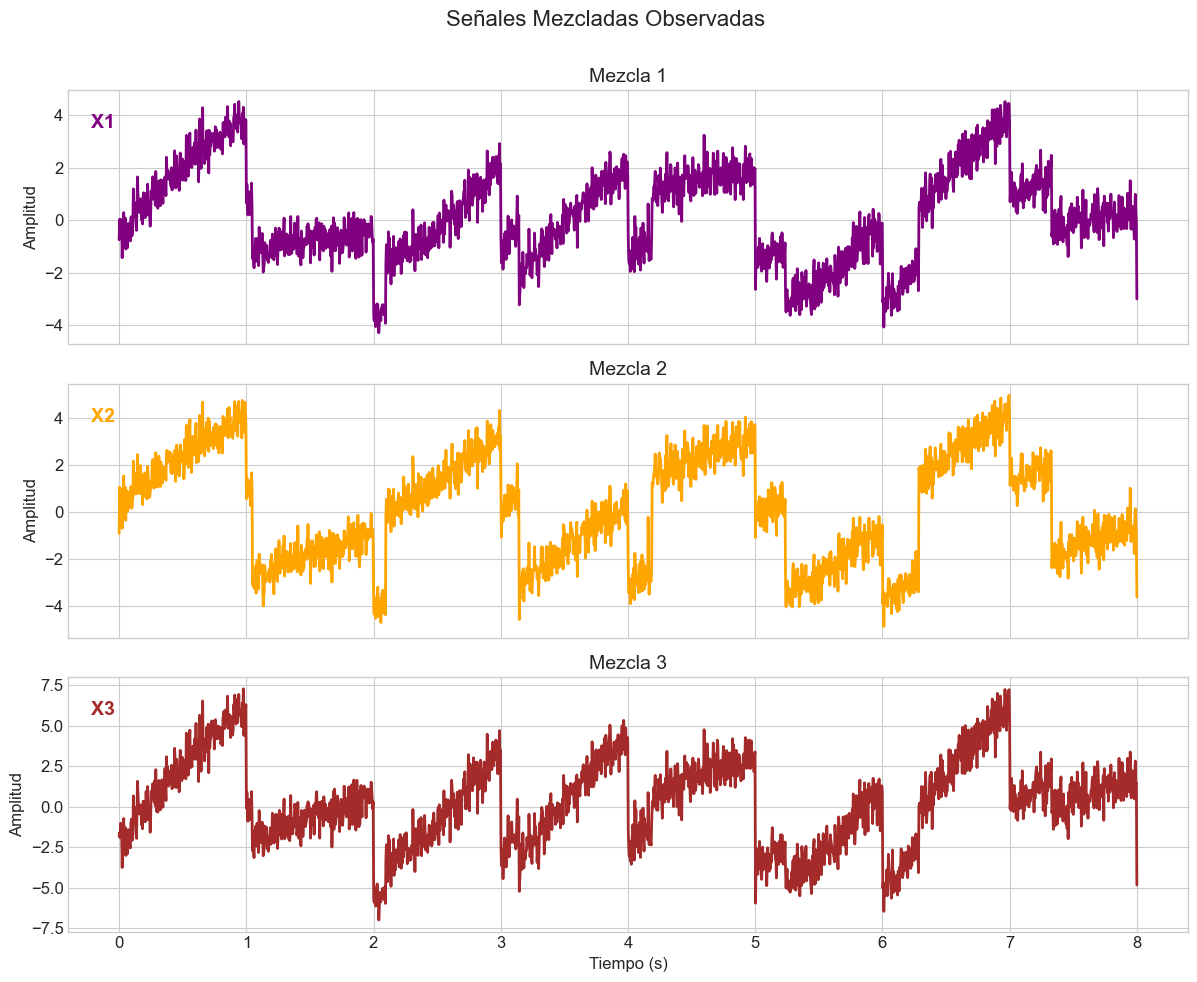

In [125]:
# Visualizamos las señales mezcladas
fig, axes = plt.subplots(X.shape[1], 1, figsize=(12, 10), sharex=True)
fig.suptitle('Señales Mezcladas Observadas', fontsize=16)

titles = ['Mezcla 1', 'Mezcla 2', 'Mezcla 3']
colors = ['purple', 'orange', 'brown']

for i, (ax, title, color) in enumerate(zip(axes, titles, colors)):
    ax.plot(time, X[:, i], color=color, lw=2)
    ax.set_title(title, fontsize=14)
    ax.set_ylabel('Amplitud', fontsize=12)
    ax.grid(True)

    # Añadimos una etiqueta para identificar la mezcla
    ax.text(0.02, 0.85, f'X{i+1}', transform=ax.transAxes, 
            fontsize=14, fontweight='bold', color=color)

axes[-1].set_xlabel('Tiempo (s)', fontsize=12)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


### Visualización de la Matriz de Mezcla

Visualizamos la matriz de mezcla para entender cómo se combinan las señales fuente:


#### Matriz de Mezcla y Visualización

La matriz de mezcla (A) es una matriz que define cómo se combinan las señales fuente originales para formar las señales mezcladas observadas. En los gráficos de calor (heatmaps) mostrados:

- Cada fila (X1, X2, X3) representa una señal mezclada observada
- Cada columna (S1, S2, S3) representa una señal fuente original
- Los valores numéricos y colores indican el "peso" o contribución de cada señal fuente a cada mezcla:
  - Colores más claros (amarillo) indican mayor contribución
  - Colores más oscuros (azul) indican menor contribución
  - El valor numérico exacto indica la proporción de la señal fuente en la mezcla

Por ejemplo, un valor de 2.0 significa que esa señal fuente contribuye con el doble de su amplitud original a la mezcla correspondiente, mientras que un valor de 0.5 significa que contribuye con la mitad.


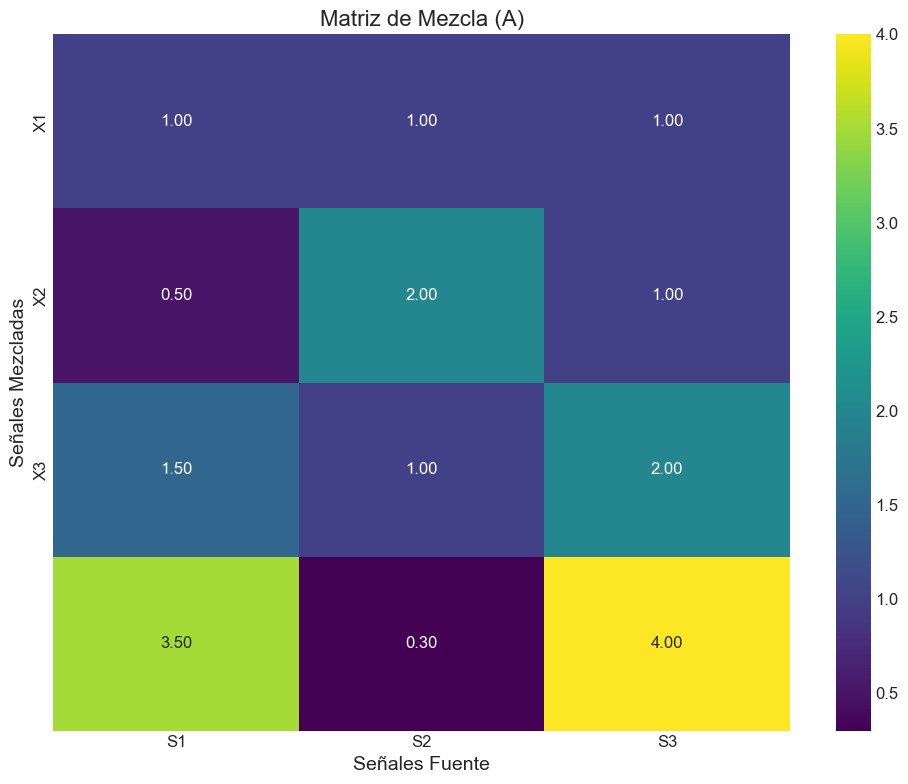

In [96]:
# Visualizamos la matriz de mezcla
plt.figure(figsize=(10, 8))
sns.heatmap(A, annot=True, cmap='viridis', fmt='.2f',
            xticklabels=['S1', 'S2', 'S3'],
            yticklabels=['X1', 'X2', 'X3'])
plt.title('Matriz de Mezcla (A)', fontsize=16)
plt.xlabel('Señales Fuente', fontsize=14)
plt.ylabel('Señales Mezcladas', fontsize=14)
plt.tight_layout()
plt.show()


## 4. Aplicación de ICA para Separar las Señales

Ahora aplicaremos ICA para recuperar las señales fuente originales a partir de las mezclas observadas.


In [120]:
# Aplicamos FastICA de scikit-learn
ica = FastICA(n_components=4)
S_est = ica.fit_transform(X)  # Estimamos las fuentes
A_est = ica.mixing_  # Estimamos la matri.z de mezcla

print("Forma de la matriz de mezcla estimada:", A_est.shape)
print("Forma de las señales fuente estimadas:", S_est.shape)


Forma de la matriz de mezcla estimada: (4, 4)
Forma de las señales fuente estimadas: (2000, 4)


### Visualización de las Señales Recuperadas

Visualizamos las señales fuente recuperadas por ICA:


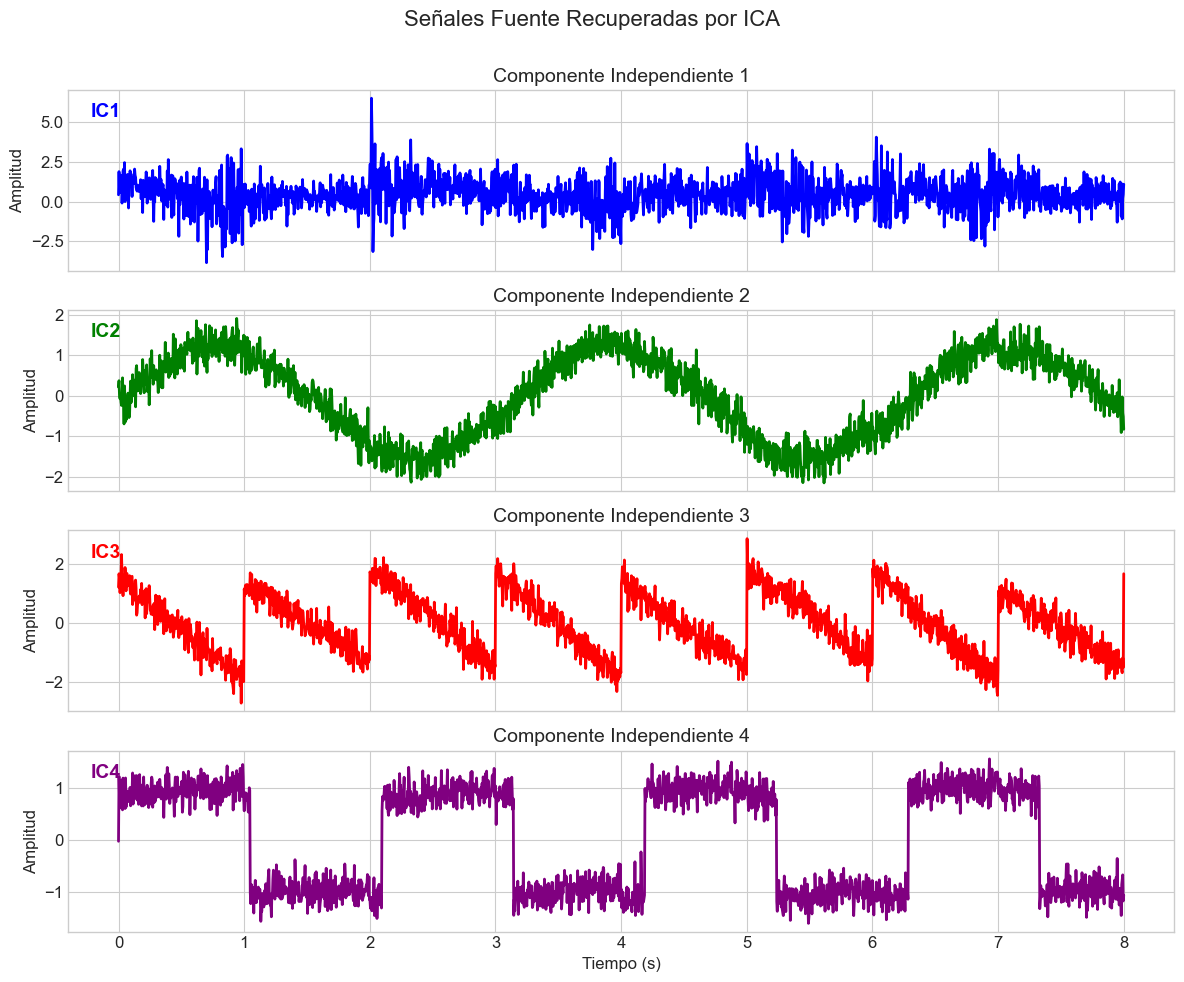

In [121]:
# Visualizamos las señales recuperadas
fig, axes = plt.subplots(S_est.shape[1], 1, figsize=(12, 10), sharex=True)
fig.suptitle('Señales Fuente Recuperadas por ICA', fontsize=16)

colors = ['blue', 'green', 'red', 'purple']
titles = ['Componente Independiente 1', 'Componente Independiente 2', 'Componente Independiente 3', 'Componente Independiente 4']

for i, (ax, title, color) in enumerate(zip(axes, titles, colors)):
    try:
        ax.plot(time, S_est[:, i], color=color, lw=2)
        ax.set_title(title, fontsize=14)
        ax.set_ylabel('Amplitud', fontsize=12)
        ax.grid(True)
    except:
        continue

    # Añadimos una etiqueta para identificar el componente
    ax.text(0.02, 0.85, f'IC{i+1}', transform=ax.transAxes, 
            fontsize=14, fontweight='bold', color=color)

axes[-1].set_xlabel('Tiempo (s)', fontsize=12)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


### Comparación de Señales Originales y Recuperadas

Comparamos las señales fuente originales con las recuperadas por ICA:


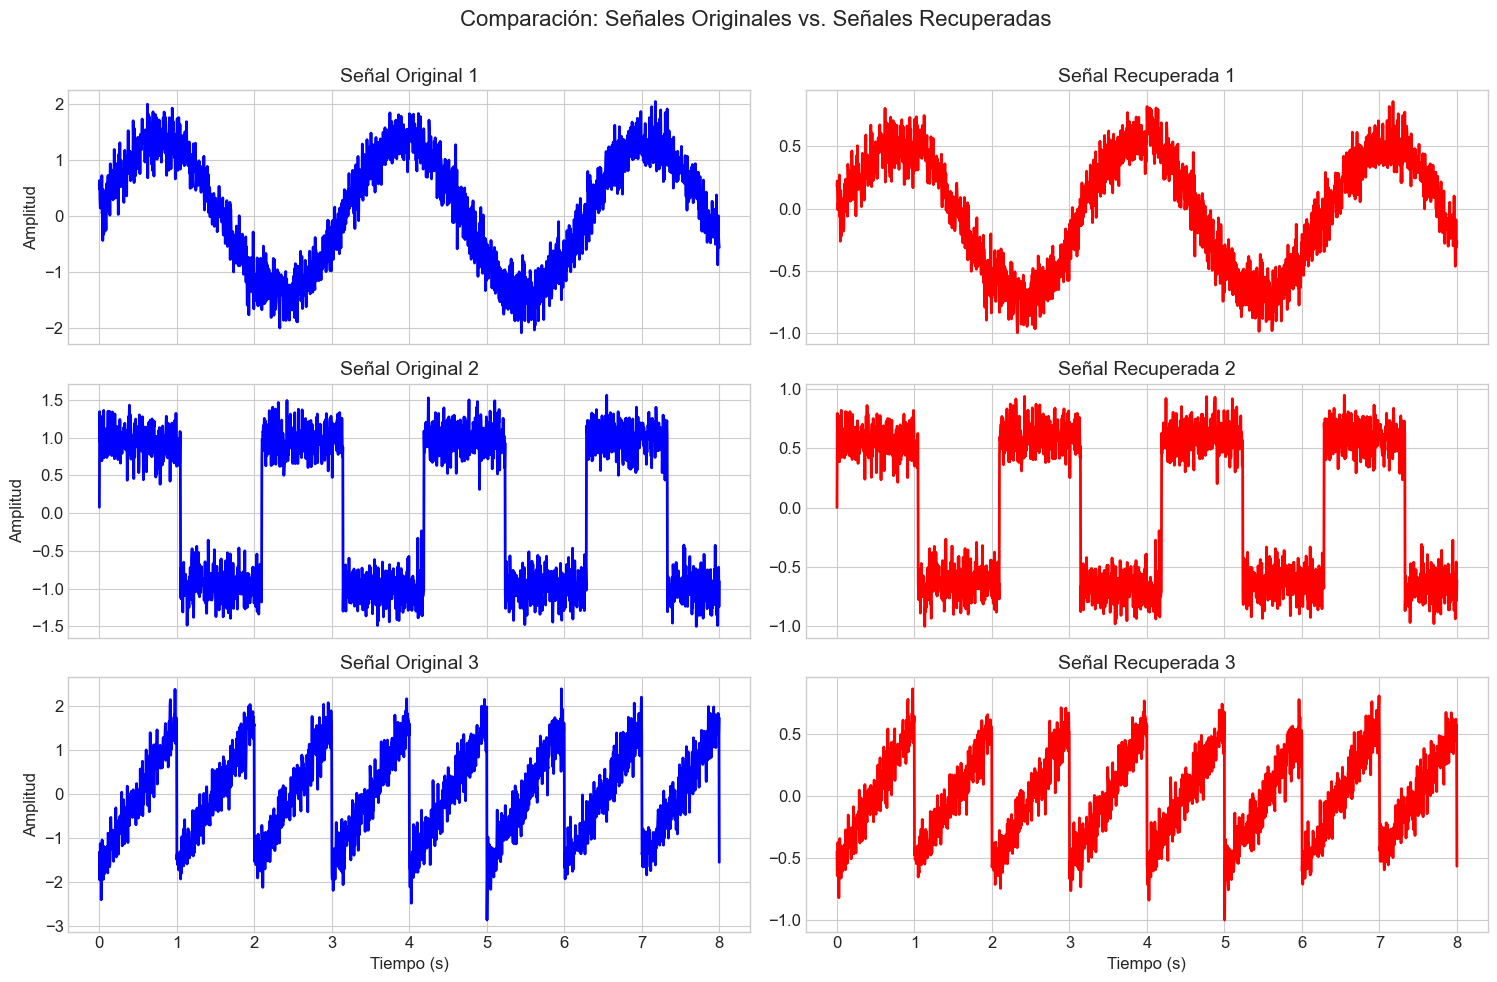

In [118]:
# Comparamos las señales originales con las recuperadas
fig, axes = plt.subplots(S_est.shape[1], 2, figsize=(15, 10), sharex='col')
fig.suptitle('Comparación: Señales Originales vs. Señales Recuperadas', fontsize=16)

# Normalizamos las señales recuperadas para facilitar la comparación
S_est_norm = S_est.copy()
for i in range(S_est.shape[1]):
    S_est_norm[:, i] = S_est[:, i] / np.max(np.abs(S_est[:, i]))

    # Corregimos el signo si es necesario (ICA puede invertir el signo)
    corr = np.corrcoef(S[:, i], S_est_norm[:, i])[0, 1]
    if corr < 0:
        S_est_norm[:, i] = -S_est_norm[:, i]

# Visualizamos las señales originales y recuperadas
for i in range(S.shape[1]):
    # Señal original
    axes[i, 0].plot(time, S[:, i], 'b-', lw=2)
    axes[i, 0].set_title(f'Señal Original {i+1}', fontsize=14)
    axes[i, 0].set_ylabel('Amplitud', fontsize=12)
    axes[i, 0].grid(True)

    # Señal recuperada
    axes[i, 1].plot(time, S_est_norm[:, i], 'r-', lw=2)
    axes[i, 1].set_title(f'Señal Recuperada {i+1}', fontsize=14)
    axes[i, 1].grid(True)

axes[2, 0].set_xlabel('Tiempo (s)', fontsize=12)
axes[2, 1].set_xlabel('Tiempo (s)', fontsize=12)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


### Visualización de la Matriz de Mezcla Estimada

Visualizamos la matriz de mezcla estimada por ICA:


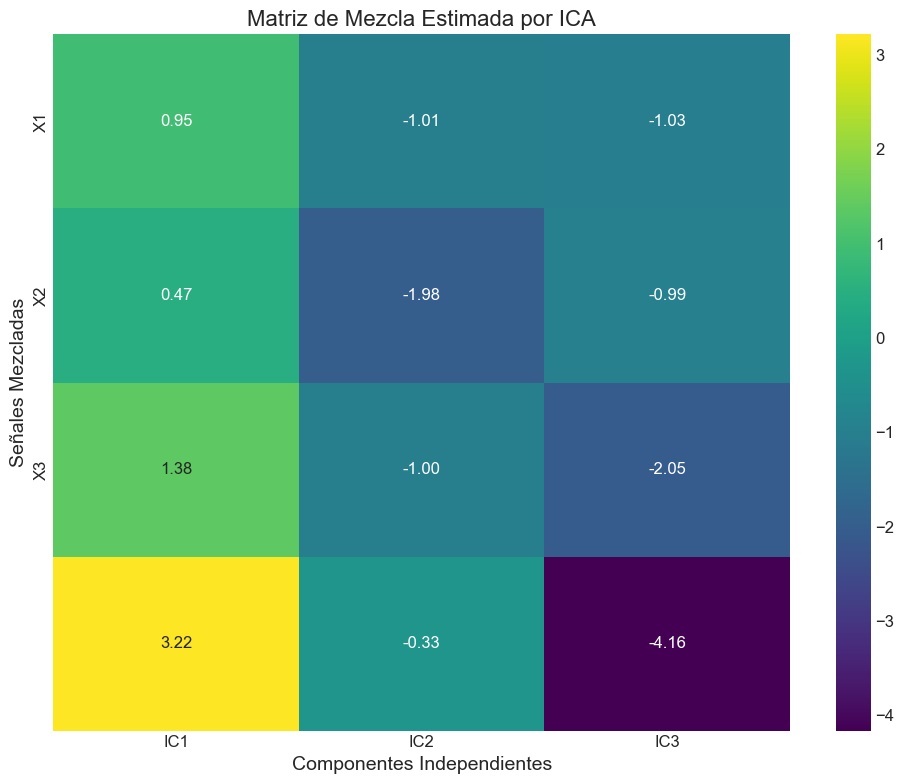

In [116]:
# Visualizamos la matriz de mezcla estimada
plt.figure(figsize=(10, 8))
sns.heatmap(A_est, annot=True, cmap='viridis', fmt='.2f',
            xticklabels=['IC1', 'IC2', 'IC3'],
            yticklabels=['X1', 'X2', 'X3'])
plt.title('Matriz de Mezcla Estimada por ICA', fontsize=16)
plt.xlabel('Componentes Independientes', fontsize=14)
plt.ylabel('Señales Mezcladas', fontsize=14)
plt.tight_layout()
plt.show()


## 5. Evaluación de la Calidad de la Separación

Evaluamos qué tan bien ICA ha separado las señales originales.


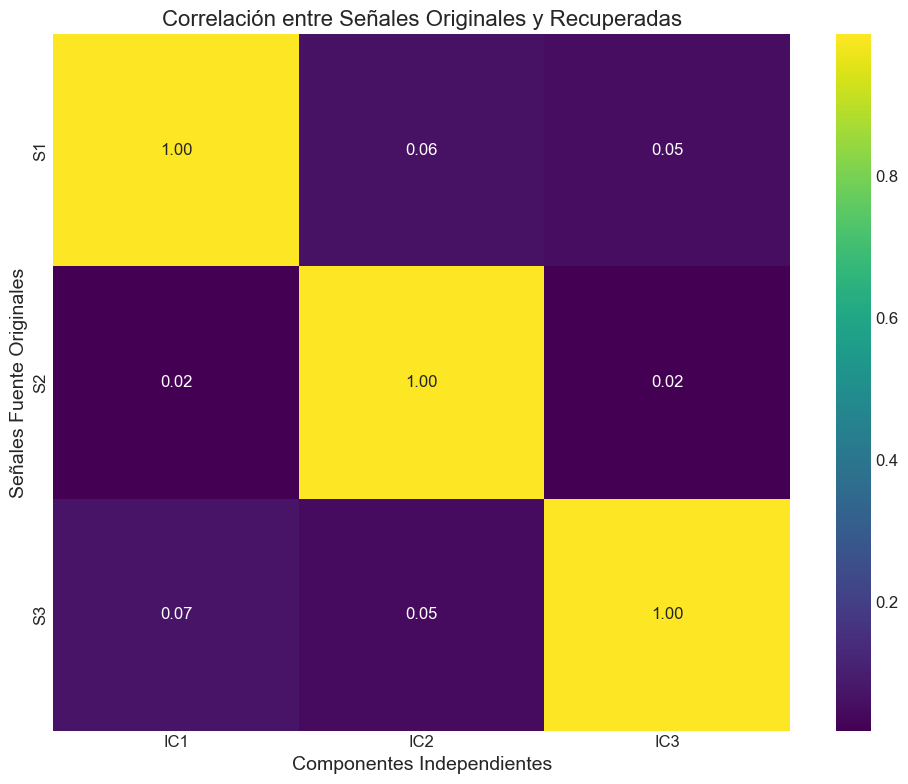

In [114]:
# Calculamos la correlación entre las señales originales y las recuperadas
correlation_matrix = np.zeros((S.shape[1], S.shape[1]))

for i in range(S.shape[1]):
    for j in range(S.shape[1]):
        # Calculamos la correlación absoluta (ICA puede invertir el signo)
        correlation_matrix[i, j] = np.abs(np.corrcoef(S[:, i], S_est[:, j])[0, 1])

# Visualizamos la matriz de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', fmt='.2f',
            xticklabels=['IC1', 'IC2', 'IC3'],
            yticklabels=['S1', 'S2', 'S3'])
plt.title('Correlación entre Señales Originales y Recuperadas', fontsize=16)
plt.xlabel('Componentes Independientes', fontsize=14)
plt.ylabel('Señales Fuente Originales', fontsize=14)
plt.tight_layout()
plt.show()


### Análisis de la Independencia de los Componentes

Verificamos la independencia de los componentes recuperados mediante histogramas y gráficos de dispersión:


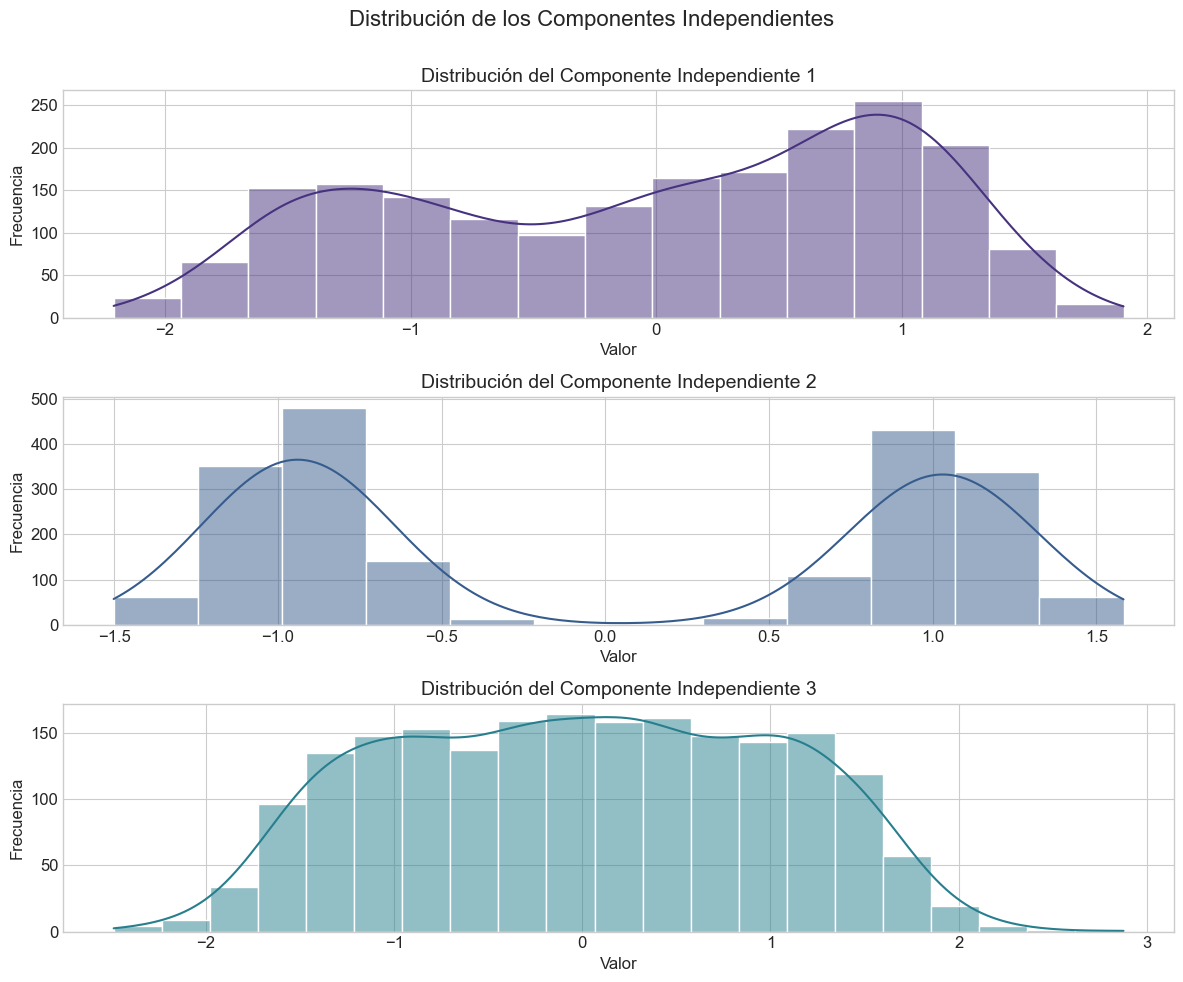

In [113]:
# Analizamos la distribución de los componentes recuperados
fig, axes = plt.subplots(S.shape[1], 1, figsize=(12, 10))
fig.suptitle('Distribución de los Componentes Independientes', fontsize=16)

for i, ax in enumerate(axes):
    sns.histplot(S_est[:, i], kde=True, ax=ax, color=f'C{i}')
    ax.set_title(f'Distribución del Componente Independiente {i+1}', fontsize=14)
    ax.set_xlabel('Valor', fontsize=12)
    ax.set_ylabel('Frecuencia', fontsize=12)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


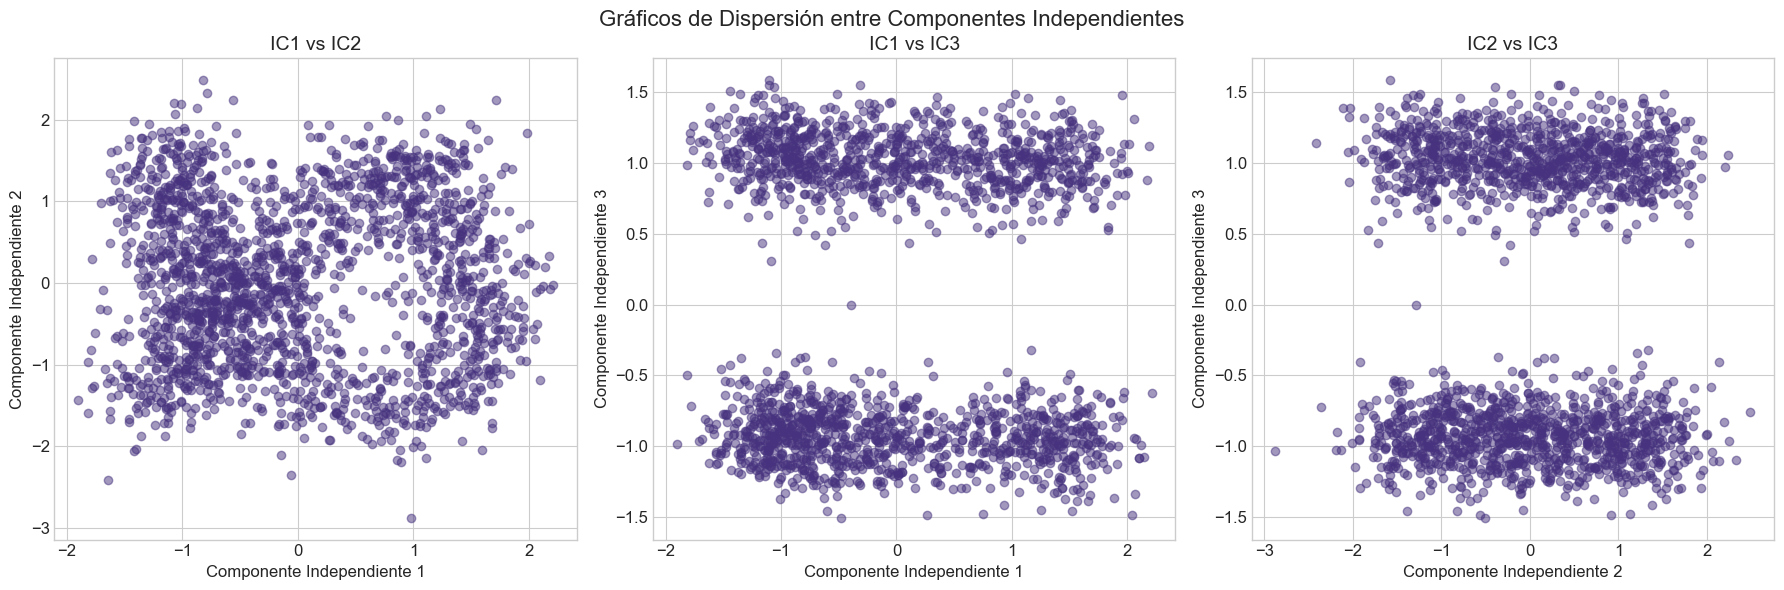

In [49]:
# Gráficos de dispersión entre componentes para verificar independencia
#
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Gráficos de Dispersión entre Componentes Independientes', fontsize=16)

# Pares de componentes a visualizar
component_pairs = [(0, 1), (0, 2), (1, 2)]

for i, (comp1, comp2) in enumerate(component_pairs):
    axes[i].scatter(S_est[:, comp1], S_est[:, comp2], alpha=0.5)
    axes[i].set_title(f'IC{comp1+1} vs IC{comp2+1}', fontsize=14)
    axes[i].set_xlabel(f'Componente Independiente {comp1+1}', fontsize=12)
    axes[i].set_ylabel(f'Componente Independiente {comp2+1}', fontsize=12)
    axes[i].grid(True)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


Los gráficos de dispersión entre componentes muestran la relación entre pares de componentes independientes (IC) recuperados por ICA. Su interpretación es la siguiente:

1. Cada gráfico muestra la relación entre dos componentes independientes, donde:
   - El eje X representa los valores de un componente (ICx)
   - El eje Y representa los valores del otro componente (ICy)

2. Los puntos dispersos representan las observaciones para cada par de componentes

3. Para verificar independencia:
   - Si los puntos forman patrones o estructuras claras (líneas, curvas, clusters), indica que los componentes NO son totalmente independientes
   - Si los puntos están distribuidos uniformemente sin patrones claros (como una "nube" uniforme), sugiere que los componentes SI son independientes

4. Interpretación clave:
   - A mayor aleatoriedad en la dispersión → Mayor independencia
   - A mayor presencia de patrones → Menor independencia
   - Una forma circular o elíptica uniforme sugiere buena independencia

Esta visualización es crucial para validar que ICA ha logrado separar efectivamente las señales en componentes verdaderamente independientes.


## 6. Efecto del Ruido en ICA

Analizamos cómo el nivel de ruido afecta el rendimiento de ICA:


/Users/yeison/Development/procesamiento-senales/.venv/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/Users/yeison/Development/procesamiento-senales/.venv/lib/python3.13/site-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


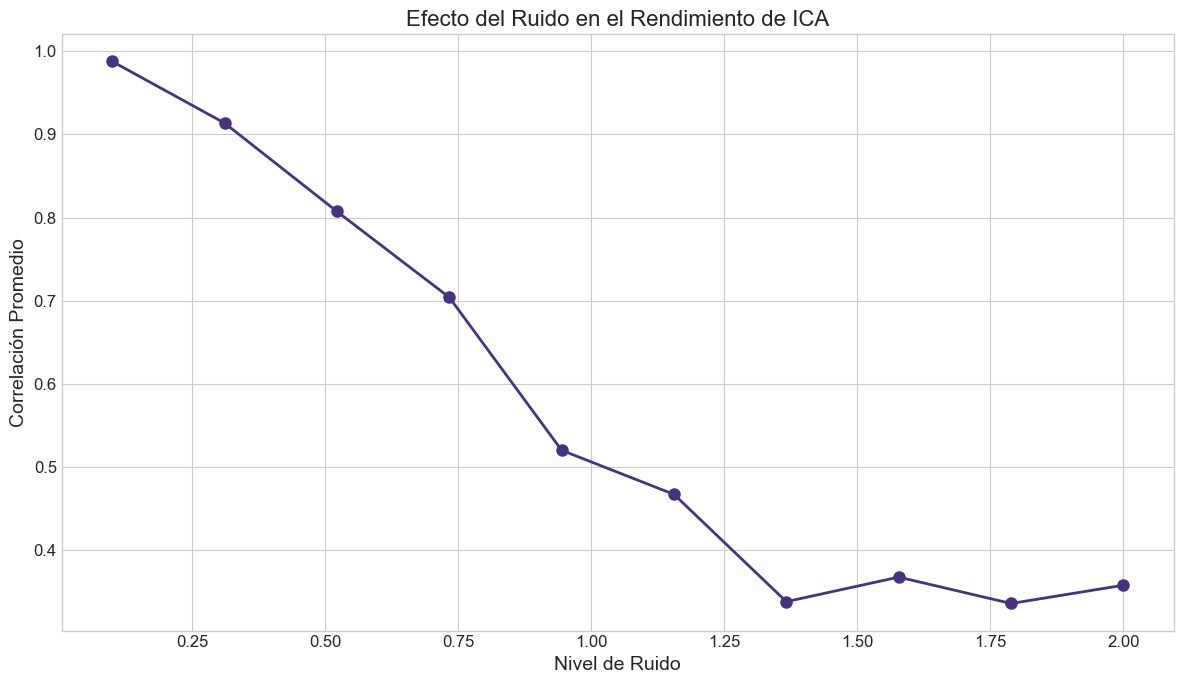

In [50]:
# Función para generar datos con diferentes niveles de ruido y aplicar ICA
def apply_ica_with_noise(noise_level):
    # Generamos las señales con el nivel de ruido especificado
    S_noisy = np.c_[s1, s2, s3] + noise_level * np.random.normal(size=(n_samples, 3))
    S_noisy /= S_noisy.std(axis=0)

    # Mezclamos las señales
    X_noisy = np.dot(S_noisy, A.T)

    # Aplicamos ICA
    ica = FastICA(n_components=3, random_state=0)
    S_est_noisy = ica.fit_transform(X_noisy)

    # Calculamos la correlación promedio entre las señales originales y recuperadas
    correlations = []
    for i in range(3):
        best_corr = 0
        for j in range(3):
            corr = np.abs(np.corrcoef(np.c_[s1, s2, s3][:, i], S_est_noisy[:, j])[0, 1])
            best_corr = max(best_corr, corr)
        correlations.append(best_corr)

    return np.mean(correlations)

# Probamos diferentes niveles de ruido
noise_levels = np.linspace(0.1, 2.0, 10)
correlations = [apply_ica_with_noise(nl) for nl in noise_levels]

# Visualizamos los resultados
plt.figure(figsize=(12, 7))
plt.plot(noise_levels, correlations, 'o-', linewidth=2, markersize=8)
plt.title('Efecto del Ruido en el Rendimiento de ICA', fontsize=16)
plt.xlabel('Nivel de Ruido', fontsize=14)
plt.ylabel('Correlación Promedio', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


## 7. Aplicaciones Prácticas de ICA

### 7.1 Eliminación de Artefactos en Señales EEG

Una aplicación común de ICA es la eliminación de artefactos en señales de electroencefalograma (EEG). Los artefactos como parpadeos, movimientos oculares o actividad muscular pueden ser identificados como componentes independientes y eliminados.

### 7.2 Separación de Fuentes de Audio

ICA puede separar diferentes fuentes de audio mezcladas, como en el problema del "cocktail party".

### 7.3 Análisis de Imágenes

En procesamiento de imágenes, ICA puede identificar características independientes y separar componentes como sombras, texturas o bordes.

### 7.4 Análisis de Datos Financieros

ICA puede identificar factores independientes que afectan a los mercados financieros, ayudando a entender mejor las dinámicas subyacentes.


## 8. Limitaciones de ICA

A pesar de su potencia, ICA tiene algunas limitaciones importantes:

1. **Ambigüedad de escala**: ICA no puede determinar la varianza (energía) de los componentes independientes.

2. **Ambigüedad de signo**: ICA puede recuperar los componentes con el signo invertido.

3. **Ambigüedad de orden**: ICA no proporciona los componentes en un orden específico, a diferencia de PCA.

4. **Supuesto de no gaussianidad**: ICA no funciona bien si las fuentes tienen distribución gaussiana.

5. **Número de componentes**: ICA requiere conocer o estimar el número de fuentes.

6. **Mezcla lineal**: ICA asume que la mezcla es lineal, lo que no siempre es cierto en aplicaciones reales.


## 9. Conclusión

En este notebook, hemos explorado el Análisis de Componentes Independientes (ICA) paso a paso:

1. **Fundamentos teóricos**: Entendimos el modelo matemático y los supuestos de ICA.

2. **Generación de datos**: Creamos señales fuente sintéticas y las mezclamos linealmente.

3. **Aplicación de ICA**: Utilizamos FastICA para recuperar las señales originales a partir de las mezclas.

4. **Evaluación**: Analizamos la calidad de la separación y la independencia de los componentes recuperados.

5. **Efecto del ruido**: Estudiamos cómo el ruido afecta el rendimiento de ICA.

6. **Aplicaciones y limitaciones**: Discutimos las aplicaciones prácticas y las limitaciones de ICA.

ICA es una herramienta poderosa en procesamiento de señales que permite separar fuentes mezcladas sin conocimiento previo de la mezcla o las fuentes originales. Su capacidad para encontrar componentes estadísticamente independientes la hace invaluable en numerosas aplicaciones donde las señales de interés están mezcladas con otras señales o ruido.


## 10. Referencias

1. Hyvärinen, A., & Oja, E. (2000). Independent component analysis: algorithms and applications. Neural networks, 13(4-5), 411-430.

2. Stone, J. V. (2004). Independent component analysis: a tutorial introduction. MIT press.

3. Comon, P. (1994). Independent component analysis, a new concept? Signal processing, 36(3), 287-314.

4. Documentación de scikit-learn sobre FastICA: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html
